Algorithm from http://www.ict.nsc.ru/matmod/files/textbooks/KhakimzyanovCherny-2.pdf

In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [58]:
def tridiagonal_matrix_algorithm(
    number_of_equations,
    a_coefficients,
    b_coefficients,
    c_coefficients,
    d_coefficients,
    y,
):
    for i in range(1, number_of_equations):
        b_coefficients[i] -= (
            a_coefficients[i] / b_coefficients[i - 1] * c_coefficients[i - 1]
        )
        d_coefficients[i] -= (
            a_coefficients[i] / b_coefficients[i - 1] * d_coefficients[i - 1]
        )

    y[number_of_equations - 1] = (
        d_coefficients[number_of_equations - 1]
        / b_coefficients[number_of_equations - 1]
    )
    for i in range(number_of_equations - 1, 0, -1):
        j = i - 1
        y[j] = (d_coefficients[j] - c_coefficients[j] * y[j + 1]) / b_coefficients[j]
    return y

In [59]:
def basis_function(x_values, h, n, i, x):
    if i == n:
        if x_values[n - 1] <= x <= x_values[n]:
            return (x - x_values[n - 1]) / h
        else:
            return 0
    elif i == 0:
        if x_values[0] <= x <= x_values[1]:
            return (x_values[1] - x) / h
        else:
            return 0
    else:
        if x_values[i - 1] <= x <= x_values[i]:
            return (x - x_values[i - 1]) / h
        elif x_values[i] <= x <= x_values[i + 1]:
            return (x_values[i + 1] - x) / h
        else:
            return 0

In [60]:
def dot_f_basis(λ, x_values, h, i):
    x_left = x_values[i - 1]
    x_curr = x_values[i]
    x_right = x_values[i + 1]

    return (
        2
        * (
            -(x_curr - x_right) * math.sqrt(λ) * math.cos(x_curr * math.sqrt(λ))
            + math.sin(x_curr * math.sqrt(λ))
            - math.sin(x_right * math.sqrt(λ))
        )
        + 2
        * (
            -math.sqrt(λ) * (x_curr - x_left) * math.cos(x_curr * math.sqrt(λ))
            + math.sin(x_curr * math.sqrt(λ))
            - math.sin(math.sqrt(λ) * x_left)
        )
    ) / h

def dot_basis(λ, x_values, h, i, j):
    if i > j:
        i, j = j, i

    x_left = x_values[i - 1]
    x_curr = x_values[i]
    x_right = x_values[i + 1]

    if i == j:
        return (
            λ * x_curr**2 * x_right
            - λ * x_curr * x_right**2
            + (λ * x_right**3) / 3
            - λ * x_curr**2 * x_left
            + λ * x_curr * x_left**2
            - (λ * x_left**3) / 3
            + x_right
            - x_left
        ) / h**2
    elif i + 1 == j:
        return (
            (-1 / 6.0) * (-6 + λ * (x_curr - x_right) ** 2) * (x_curr - x_right)
        ) / h**2
    else:
        return 0

In [61]:
def interpolate(x_values, y_values, h, n, x):
    l = 0
    r = n

    while r - l > 1:
        m = (l + r) // 2
        if x > x_values[m]:
            l = m
        else:
            r = m

    res = y_values[l] * basis_function(x_values, h, n, l, x) + y_values[r] * basis_function(x_values, h, n, r, x)
    return res

In [62]:
def finite_element_method(λ, l, grid_size):
    N = grid_size - 1
    h = l / (grid_size - 1)
    x_values = np.linspace(0, l, grid_size)

    n = N - 1
    a_coefficients = np.zeros(n)
    b_coefficients = np.zeros(n)
    c_coefficients = np.zeros(n)
    d_coefficients = np.zeros(n)

    for i in range(1, N):
        j = i - 1

        if i - 1 >= 1:
            a_coefficients[j] = dot_basis(λ, x_values, h, i - 1, i)

        if i + 1 < N:
            c_coefficients[j] = dot_basis(λ, x_values, h, i + 1, i)

        b_coefficients[j] = dot_basis(λ, x_values, h, i, i)
        d_coefficients[j] = dot_f_basis(λ, x_values, h, i)

    y = np.zeros(N + 1)
    tridiagonal_matrix_algorithm(n, a_coefficients, b_coefficients, c_coefficients, d_coefficients, y[1:])
    y[0] = y[N] = 0

    return x_values, y

In [63]:
def compute_error(λ, n):

    l = 4 * math.pi / math.sqrt(λ)
    x_values, y_values = finite_element_method(λ, l, n)
    theoretical_upper_bound = (l / (n - 1)) ** 2
    max_error = 0.0
    h = l / (n * 10)

    for i in range(n * 10):
        x = i * h
        interp_value = interpolate(x_values, y_values, l / (n - 1), n - 1, x)
        real_value = math.sin(math.sqrt(λ) * x)
        curr_error = abs(interp_value - real_value)

        if curr_error > max_error:
            maximum_error = curr_error
    return maximum_error, theoretical_upper_bound


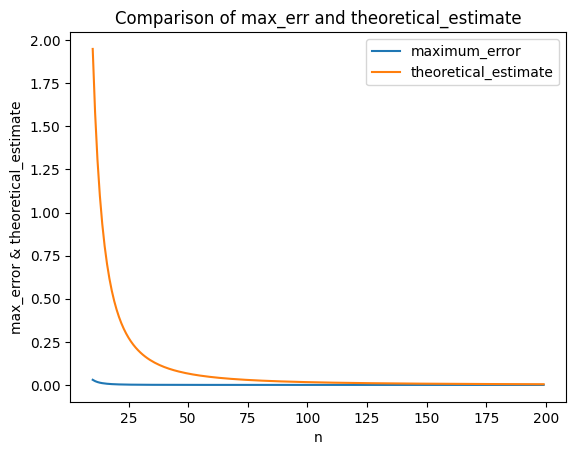

In [64]:
ns = [i for i in range(10, 200)]
maximum_error = []
theoretical_estimate = []

for n in ns:
    new_max_error, new_theoretical_estimate = compute_error(1, n)
    maximum_error.append(new_max_error)
    theoretical_estimate.append(new_theoretical_estimate)

plt.figure()
plt.plot(ns, maximum_error, label='maximum_error')
plt.plot(ns, theoretical_estimate, label='theoretical_estimate')
plt.xlabel('n')
plt.ylabel('max_error & theoretical_estimate')
plt.title('Comparison of max_err and theoretical_estimate')
plt.legend()
plt.show()